In [1]:
import numpy as np
import torch as th
import torch as th
import pandas as pd
import os, glob, sys, tqdm
from collections import defaultdict
from PIL import Image
sys.path.append('/home/mint/Dev/DiFaReli/difareli-faster/sample_scripts/sample_utils/')
import mani_utils


def sh_to_ld(sh):
    #NOTE: Roughly Convert the SH to light direction
    sh = sh.reshape(-1, 9, 3)
    ld = th.mean(sh[0:1, 1:4, :], dim=2)
    return ld

def read_params(path):
    params = pd.read_csv(path, header=None, sep=" ", index_col=False, lineterminator='\n')
    params.rename(columns={0:'img_name'}, inplace=True)
    params = params.set_index('img_name').T.to_dict('list')
    return params

def swap_key(params):
    params_s = defaultdict(dict)
    for params_name, v in params.items():
        for img_name, params_value in v.items():
            params_s[img_name][params_name] = np.array(params_value).astype(np.float64)

    return params_s

def load_deca_params(deca_dir, cfg):
    deca_params = {}

    # face params 
    params_key = ['shape', 'pose', 'exp', 'cam', 'light', 'faceemb', 'shadow', 'albedo', 'detail']
    for k in tqdm.tqdm(params_key, desc="Loading deca params..."):
        params_path = glob.glob(f"{deca_dir}/*{k}-anno.txt")
        for path in params_path:
            deca_params[k] = read_params(path=path)
    
    deca_params = swap_key(deca_params)
    return deca_params

def create_image_grid(images, n_rows=1):
    """
    Creates a grid of images from a list of NumPy arrays.
    
    Parameters:
    - images: List of np.array, each representing an image.
    - n_rows: Number of rows in the grid.
    
    Returns:
    - A matplotlib figure containing the image grid.
    """
    n_images = len(images)
    n_cols = (n_images + n_rows - 1) // n_rows  # Calculate number of columns needed
    
    # Get the height and width of the images (assuming all images are the same size)
    # img_height, img_width = images[0].shape[:2]

    # Add zero images if the number of images is less than needed to fill the grid
    images += [np.zeros_like(images[0]) for _ in range(n_rows * n_cols - n_images)]
    
    # Create the grid by concatenating images
    rows = []
    for i in range(n_rows):
        row_images = images[i * n_cols:(i + 1) * n_cols]
        rows.append(np.concatenate(row_images, axis=1))
    
    grid_image = np.concatenate(rows, axis=0)
    return grid_image

In [2]:
pth = '/data/mint/DPM_Dataset/MultiPIE/MultiPIE_testset/params/'
set_ = 'valid'

In [3]:
sys.path.append('/home/mint/Dev/DiFaReli/difareli-faster/sample_scripts/sample_utils/')
import params_utils
params = load_deca_params(deca_dir=f'{pth}/{set_}/', cfg=None)
mask = params_utils.load_flame_mask(['face'])
deca_obj = params_utils.init_deca(mask=mask)


# img_name = '68364.jpg'
# img_name = '60065.jpg'
# img_name = '001_01_01_051_06.png'
img_name = '002_01_01_051_06.png'
src_idx = 0
cond = {}
for k in params[img_name].keys():
    cond[k] = params[img_name][k][None, ]

for k in cond.keys():
    cond[k] = th.tensor(cond[k]).cuda()
    print(k, cond[k].shape)

# cond['raw_image_path'] = [f'/data/mint/DPM_Dataset/ffhq_256_with_anno/ffhq_256/{set_}/{img_name}']
cond['raw_image_path'] = [f'/data/mint/DPM_Dataset/MultiPIE/MultiPIE_testset/mp_aligned/{set_}/{img_name}']
cond['raw_image'] = th.tensor(np.array(Image.open(cond['raw_image_path'][0]))).cuda().permute(2, 0, 1).float().unsqueeze(0)/255.0
deca_rendered, orig_visdict = params_utils.render_deca(deca_params=cond, 
                                                    idx=src_idx, n=1, 
                                                    avg_dict=None, 
                                                    render_mode='shape', 
                                                    rotate_normals=False, 
                                                    mask=mask,
                                                    deca_obj=deca_obj,
                                                    repeat=True)


Loading deca params...: 100%|██████████| 9/9 [00:00<00:00, 12.05it/s]


creating the FLAME Decoder
USING STARDARD...
/home/mint/Dev/DiFaReli/difareli-faster/sample_scripts/cond_utils/DECA/decalib/utils
[#] DECA : SRenderY applied mask
shape torch.Size([1, 100])
pose torch.Size([1, 6])
exp torch.Size([1, 50])
cam torch.Size([1, 3])
light torch.Size([1, 27])
faceemb torch.Size([1, 512])
shadow torch.Size([1, 1])
albedo torch.Size([1, 50])
detail torch.Size([1, 128])
1 1


/home/mint/Dev/DiFaReli/difareli-faster/sample_scripts/sample_utils/params_utils.py:589: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'light':th.tensor(deca_params['light']).to(device).reshape(-1, 9, 3).float(),


In [5]:
def sh_to_ld(sh):
    #NOTE: Roughly Convert the SH to light direction
    sh = sh.reshape(-1, 9, 3)
    ld = th.mean(sh[0:1, 1:4, :], dim=2)
    return ld

def sh_to_ld_brightest(sh):
    from scipy.spatial.transform import Rotation as R
    from matplotlib import pyplot as plt
    import cv2

    import pyshtools as pysh

    def applySHlight(normal_images, sh_coeff):
        N = normal_images
        sh = th.stack(
            [
            N[0] * 0.0 + 1.0,
            N[0],
            N[1],
            N[2],
            N[0] * N[1],
            N[0] * N[2],
            N[1] * N[2],
            N[0] ** 2 - N[1] ** 2,
            3 * (N[2] ** 2) - 1,
            ],
            0,
        )  # [9, h, w]
        pi = np.pi
        constant_factor = th.tensor(
            [
            1 / np.sqrt(4 * pi),
            ((2 * pi) / 3) * (np.sqrt(3 / (4 * pi))),
            ((2 * pi) / 3) * (np.sqrt(3 / (4 * pi))),
            ((2 * pi) / 3) * (np.sqrt(3 / (4 * pi))),
            (pi / 4) * (3) * (np.sqrt(5 / (12 * pi))),
            (pi / 4) * (3) * (np.sqrt(5 / (12 * pi))),
            (pi / 4) * (3) * (np.sqrt(5 / (12 * pi))),
            (pi / 4) * (3 / 2) * (np.sqrt(5 / (12 * pi))),
            (pi / 4) * (1 / 2) * (np.sqrt(5 / (4 * pi))),
            ]
        ).float()
        sh = sh * constant_factor[:, None, None]

        shading = th.sum(
            sh_coeff[:, :, None, None] * sh[:, None, :, :], 0
        )  # [9, 3, h, w]
        return shading

    def applySHlightXYZ(xyz, sh):
        out = applySHlight(xyz, sh)
        # out /= pt.max(out)
        out *= 0.7
        return th.clip(out, 0, 1)

    def genSurfaceNormals(n):
        x = th.linspace(-1, 1, n)
        y = th.linspace(1, -1, n)
        y, x = th.meshgrid(y, x)

        z = (1 - x ** 2 - y ** 2)
        z[z < 0] = 0
        z = th.sqrt(z)
        return th.stack([x, y, z], 0)

    def drawSphere(sh, img_size=256):
        n = img_size
        xyz = genSurfaceNormals(n)
        out = applySHlightXYZ(xyz, sh)
        out[:, xyz[2] == 0] = 0
        return out, xyz
    
    sh = sh.reshape(-1, 9, 3)[0]
    visible_sphere, normals_sphere = drawSphere(sh)
    visible_sphere = visible_sphere.permute(1, 2, 0).cpu().numpy()
    # plt.imshow(visible_sphere)
    # plt.show()
    # Locate the brightest point
    visible_sphere_draw = (visible_sphere.copy() * 255).astype(np.uint8)
    
    # Gray scale
    # visible_sphere_tmp = cv2.cvtColor(visible_sphere_draw, cv2.COLOR_RGB2GRAY)
    # brightest = np.unravel_index(visible_sphere_tmp.argmax(), visible_sphere_tmp.shape)
    
    # RGB
    visible_sphere_tmp = visible_sphere_draw.sum(axis=2)
    brightest = np.unravel_index(visible_sphere_tmp.argmax(), visible_sphere_tmp.shape)
    cv2.circle(visible_sphere_draw, (brightest[1], brightest[0]), 5, (255, 0, 0), -1)
    # print(visible_sphere_draw.shape)
    # print(brightest)
    
    # plt.imshow(visible_sphere_draw, cmap='gray')
    # plt.show()
    cv2.circle(visible_sphere_draw, (brightest[1], brightest[0]), 5, (0, 0, 255), -1)
    # plt.imshow(visible_sphere_draw, cmap='gray')
    # plt.show()
    # Center is at (128, 128)
    # light direction is vector from center to brightest point, aka the index in normal_sphere
    
    bright_area = np.isclose(a=visible_sphere_tmp, b=visible_sphere_tmp.max(), atol=np.std(visible_sphere_tmp)*0.1)
    # plt.imshow(bright_area)
    # plt.show()
    
    normals_sphere = normals_sphere.permute(1, 2, 0).cpu().numpy()
    light_direction = normals_sphere[brightest[0], brightest[1]]
    
    import plotly.graph_objects as go
    
    # fig = go.Figure()
    # fig.add_trace(go.Scatter3d(x=normals_sphere[:, :, 0].flatten(),
    #                            y=normals_sphere[:, :, 1].flatten(),
    #                            z=normals_sphere[:, :, 2].flatten(),
    #                            mode='markers',
    #                            marker=dict(size=0.5),
    #                            name='Sphere'))
    # fig.add_trace(go.Scatter3d(x=[0, light_direction[0]], y=[0, light_direction[1]], z=[0, light_direction[2]], 
    #                            mode='markers+lines', marker=dict(size=5), name='Light Direction'))
    # fig.show()
    return th.tensor(light_direction)[None, ...], (normals_sphere, visible_sphere, visible_sphere_draw, bright_area)

ld, misc = sh_to_ld_brightest(sh=cond['light'][[0]].cpu())

In [6]:
import scipy.ndimage


def sh_to_ld_brightest_region(sh):
    from scipy.spatial.transform import Rotation as R
    from matplotlib import pyplot as plt
    import cv2

    import pyshtools as pysh

    def applySHlight(normal_images, sh_coeff):
        N = normal_images
        sh = th.stack(
            [
            N[0] * 0.0 + 1.0,
            N[0],
            N[1],
            N[2],
            N[0] * N[1],
            N[0] * N[2],
            N[1] * N[2],
            N[0] ** 2 - N[1] ** 2,
            3 * (N[2] ** 2) - 1,
            ],
            0,
        )  # [9, h, w]
        pi = np.pi
        constant_factor = th.tensor(
            [
            1 / np.sqrt(4 * pi),
            ((2 * pi) / 3) * (np.sqrt(3 / (4 * pi))),
            ((2 * pi) / 3) * (np.sqrt(3 / (4 * pi))),
            ((2 * pi) / 3) * (np.sqrt(3 / (4 * pi))),
            (pi / 4) * (3) * (np.sqrt(5 / (12 * pi))),
            (pi / 4) * (3) * (np.sqrt(5 / (12 * pi))),
            (pi / 4) * (3) * (np.sqrt(5 / (12 * pi))),
            (pi / 4) * (3 / 2) * (np.sqrt(5 / (12 * pi))),
            (pi / 4) * (1 / 2) * (np.sqrt(5 / (4 * pi))),
            ]
        ).float()
        sh = sh * constant_factor[:, None, None]

        shading = th.sum(
            sh_coeff[:, :, None, None] * sh[:, None, :, :], 0
        )  # [9, 3, h, w]
        return shading

    def applySHlightXYZ(xyz, sh):
        out = applySHlight(xyz, sh)
        # out /= pt.max(out)
        out *= 0.7
        return th.clip(out, 0, 1)

    def genSurfaceNormals(n):
        x = th.linspace(-1, 1, n)
        y = th.linspace(1, -1, n)
        y, x = th.meshgrid(y, x)

        z = (1 - x ** 2 - y ** 2)
        z[z < 0] = 0
        z = th.sqrt(z)
        return th.stack([x, y, z], 0)

    def drawSphere(sh, img_size=256):
        n = img_size
        xyz = genSurfaceNormals(n)
        out = applySHlightXYZ(xyz, sh)
        out[:, xyz[2] == 0] = 0
        return out, xyz
    
    sh = sh.reshape(-1, 9, 3)[0]
    visible_sphere, normals_sphere = drawSphere(sh)
    visible_sphere = visible_sphere.permute(1, 2, 0).cpu().numpy()
    # plt.imshow(visible_sphere)
    # plt.show()
    # Locate the brightest point
    visible_sphere_draw = (visible_sphere.copy() * 255).astype(np.uint8)
    
    # Gray scale
    # visible_sphere_tmp = cv2.cvtColor(visible_sphere_draw, cv2.COLOR_RGB2GRAY)
    # brightest = np.unravel_index(visible_sphere_tmp.argmax(), visible_sphere_tmp.shape)
    
    # RGB
    visible_sphere_tmp = visible_sphere_draw.sum(axis=2)
    brightest = np.unravel_index(visible_sphere_tmp.argmax(), visible_sphere_tmp.shape)
    cv2.circle(visible_sphere_draw, (brightest[1], brightest[0]), 5, (255, 0, 0), -1)
    # print(visible_sphere_draw.shape)
    # print(brightest)
    
    # plt.imshow(visible_sphere_draw, cmap='gray')
    # plt.show()
    cv2.circle(visible_sphere_draw, (brightest[1], brightest[0]), 5, (0, 0, 255), -1)
    # plt.imshow(visible_sphere_draw, cmap='gray')
    # plt.show()
    # Center is at (128, 128)
    # light direction is vector from center to brightest point, aka the index in normal_sphere
    
    bright_area = np.isclose(a=visible_sphere_tmp, b=visible_sphere_tmp.max(), atol=np.std(visible_sphere_tmp)*0.1)
    import scipy
    cm = scipy.ndimage.center_of_mass(bright_area)
    
    # print(bright_area.shape)
    bright_area = np.repeat(bright_area[..., None] * 255, 3, axis=2).astype(np.uint8)
    cv2.circle(bright_area, (int(cm[1]), int(cm[0])), 5, (255, 0, 0), -1)
    # plt.imshow(bright_area)
    # plt.show()
    
    cv2.circle(visible_sphere_draw, (int(cm[1]), int(cm[0])), 5, (0, 255, 0), -1)
    # plt.imshow(visible_sphere_draw)
    # plt.show()
    
    normals_sphere = normals_sphere.permute(1, 2, 0).cpu().numpy()
    light_direction = normals_sphere[brightest[0], brightest[1]]
    light_direction = normals_sphere[int(cm[0]), int(cm[1])]
    
    import plotly.graph_objects as go
    
    # fig = go.Figure()
    # fig.add_trace(go.Scatter3d(x=normals_sphere[:, :, 0].flatten(),
    #                            y=normals_sphere[:, :, 1].flatten(),
    #                            z=normals_sphere[:, :, 2].flatten(),
    #                            mode='markers',
    #                            marker=dict(size=0.5),
    #                            name='Sphere'))
    # fig.add_trace(go.Scatter3d(x=[0, light_direction[0]], y=[0, light_direction[1]], z=[0, light_direction[2]], 
    #                            mode='markers+lines', marker=dict(size=5), name='Light Direction'))
    # fig.show()
    return th.tensor(light_direction)[None, ...], (normals_sphere, visible_sphere, visible_sphere_draw, bright_area)

ld, misc = sh_to_ld_brightest_region(sh=cond['light'][[0]].cpu())
print("Light Direction (region):", ld, ld.shape)
ld = sh_to_ld(cond['light'][0].cpu())
print("Light Direction (sh):", ld, ld.shape)


Light Direction (region): tensor([[ 0.3020, -0.1373,  0.9434]]) torch.Size([1, 3])
Light Direction (sh): tensor([[ 0.2511,  0.0224, -0.2400]], dtype=torch.float64) torch.Size([1, 3])


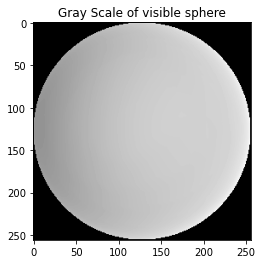

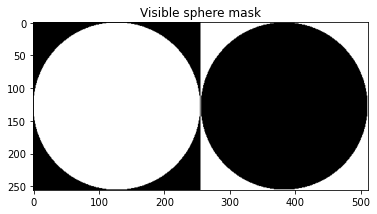

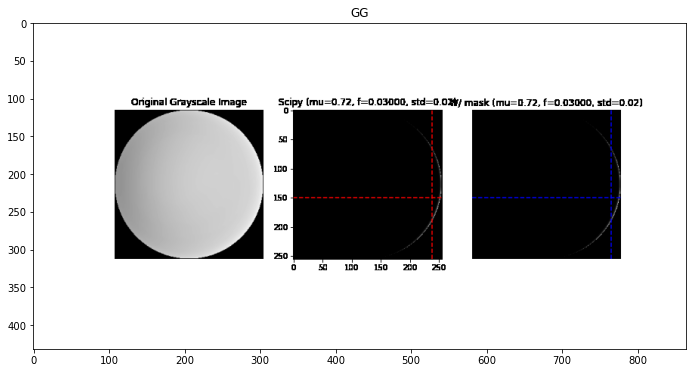

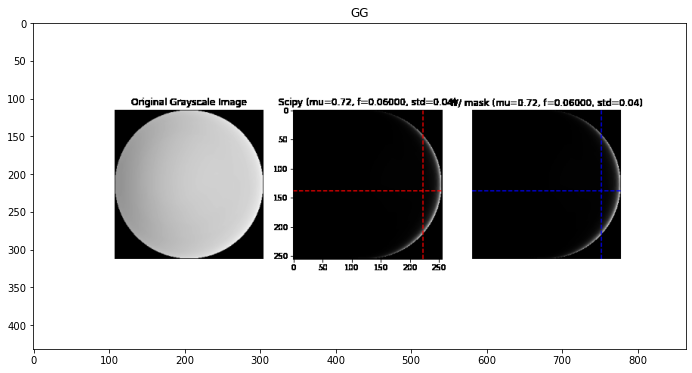

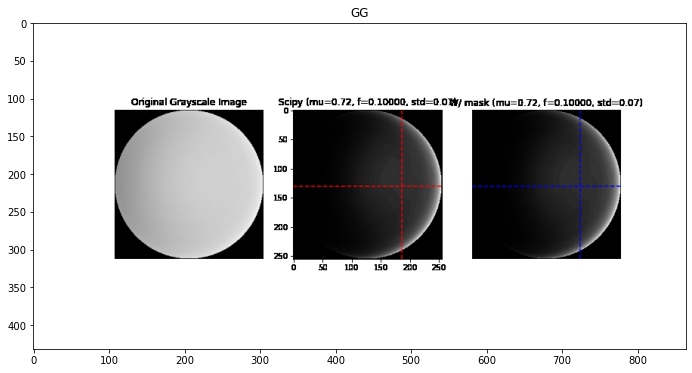

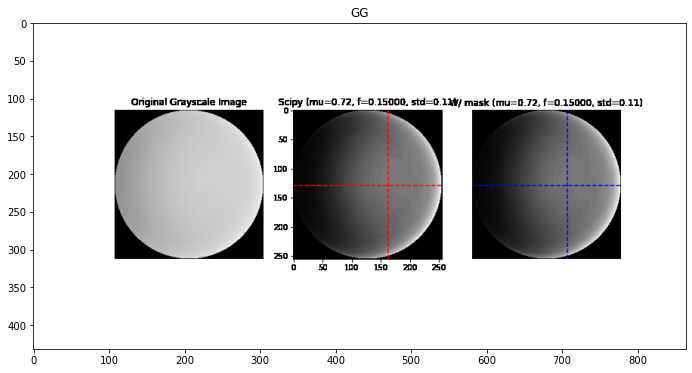

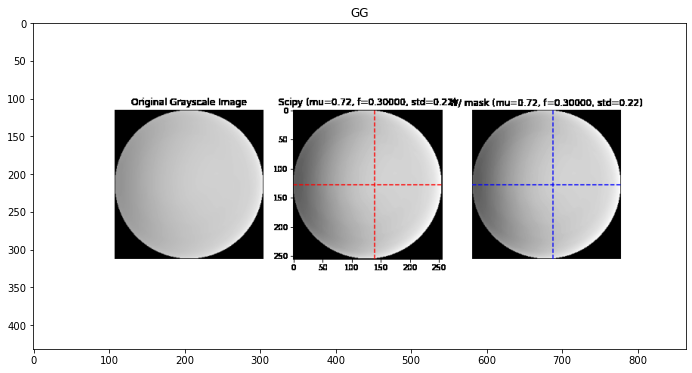

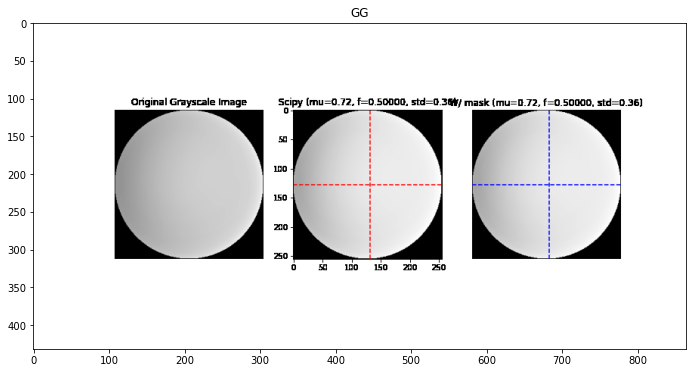

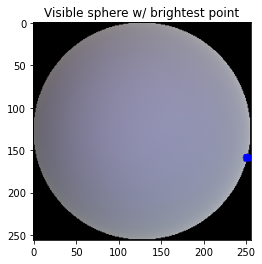

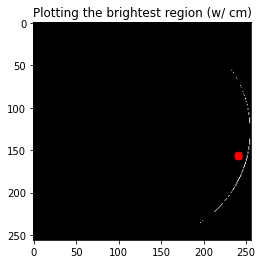

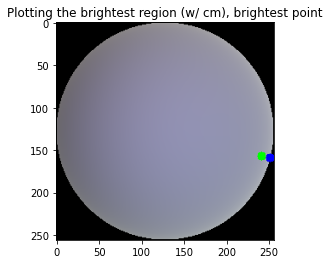

Light Direction (region): tensor([[ 0.8902, -0.2314,  0.3925]]) torch.Size([1, 3])
Light Direction (sh): tensor([[ 0.2026, -0.0250, -0.3163]], dtype=torch.float64) torch.Size([1, 3])


In [6]:
def sh_to_ld_brightest_region_G(sh):
    from scipy.spatial.transform import Rotation as R
    from matplotlib import pyplot as plt
    import cv2
    from scipy.stats import norm
    import scipy

    import pyshtools as pysh

    def applySHlight(normal_images, sh_coeff):
        N = normal_images
        sh = th.stack(
            [
            N[0] * 0.0 + 1.0,
            N[0],
            N[1],
            N[2],
            N[0] * N[1],
            N[0] * N[2],
            N[1] * N[2],
            N[0] ** 2 - N[1] ** 2,
            3 * (N[2] ** 2) - 1,
            ],
            0,
        )  # [9, h, w]
        pi = np.pi
        constant_factor = th.tensor(
            [
            1 / np.sqrt(4 * pi),
            ((2 * pi) / 3) * (np.sqrt(3 / (4 * pi))),
            ((2 * pi) / 3) * (np.sqrt(3 / (4 * pi))),
            ((2 * pi) / 3) * (np.sqrt(3 / (4 * pi))),
            (pi / 4) * (3) * (np.sqrt(5 / (12 * pi))),
            (pi / 4) * (3) * (np.sqrt(5 / (12 * pi))),
            (pi / 4) * (3) * (np.sqrt(5 / (12 * pi))),
            (pi / 4) * (3 / 2) * (np.sqrt(5 / (12 * pi))),
            (pi / 4) * (1 / 2) * (np.sqrt(5 / (4 * pi))),
            ]
        ).float()
        sh = sh * constant_factor[:, None, None]

        shading = th.sum(
            sh_coeff[:, :, None, None] * sh[:, None, :, :], 0
        )  # [9, 3, h, w]
        return shading

    def applySHlightXYZ(xyz, sh):
        out = applySHlight(xyz, sh)
        # out /= pt.max(out)
        out *= 0.7
        return th.clip(out, 0, 1)

    def genSurfaceNormals(n):
        x = th.linspace(-1, 1, n)
        y = th.linspace(1, -1, n)
        y, x = th.meshgrid(y, x)

        z = (1 - x ** 2 - y ** 2)
        z[z < 0] = 0
        # plt.imshow(z!=0, cmap='gray')
        # plt.title('zzz')
        # plt.show()
        z = th.sqrt(z)
        return th.stack([x, y, z], 0)

    def drawSphere(sh, img_size=256):
        n = img_size
        xyz = genSurfaceNormals(n)
        out = applySHlightXYZ(xyz, sh)
        out[:, xyz[2] == 0] = 0
        return out, xyz
    
    sh = sh.reshape(-1, 9, 3)[0]
    visible_sphere, normals_sphere = drawSphere(sh)
    visible_sphere = visible_sphere.permute(1, 2, 0).cpu().numpy()
    
    # Locate the brightest point
    visible_sphere_draw = (visible_sphere.copy() * 255).astype(np.uint8)
    
    # Gray scale
    visible_sphere_proc = cv2.cvtColor(visible_sphere_draw, cv2.COLOR_RGB2GRAY)
    plt.imshow(visible_sphere_proc, cmap='gray')
    plt.title("Gray Scale of visible sphere")
    plt.show()
    
    mask = (normals_sphere[2:3].permute(1, 2, 0) != 0).cpu().numpy()
    plt.imshow(np.concatenate(((mask), (normals_sphere[2:3].permute(1, 2, 0) <=0)), axis=1) * 1.0, cmap='gray')
    plt.title("Visible sphere mask")
    plt.show()
    
    # Use gaussian dist to weighting the whole sphere and control the neighbour's contribution using std
    visible_sphere_draw_G = visible_sphere_proc.copy()
    # out_G = []
    # for ratio in [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]:
    #     # x = np.exp(-((visible_sphere_draw_G - visible_sphere_draw_G.max())**2) / (2 * (np.std(visible_sphere_draw_G[visible_sphere_draw_G>0]) * ratio)**2))
    #     tmp = np.random.normal(loc=visible_sphere_draw_G.max(), scale=np.std(visible_sphere_draw_G[visible_sphere_draw_G>0]) * ratio, size=visible_sphere_draw_G.shape)
    #     print(tmp, tmp.shape, tmp.max(), tmp.min())
    #     # x = np.exp(-(((visible_sphere_draw_G - np.mean(visible_sphere_draw_G[visible_sphere_proc>0])))**2) / (2 * (np.std(visible_sphere_draw_G[visible_sphere_proc>0]) * ratio)**2))
    #     # out_G.append(x.copy())
    #     plt.imshow(np.sort(tmp) > visible_sphere_draw_G.max(), cmap='gray')
    #     plt.title(f"Gaussian of visible sphere (ratio: {ratio})")
    #     plt.show()
        
    
    intensity_values = visible_sphere_proc.copy()

    # Normalize the intensity values to [0, 1]
    normalized_intensities = intensity_values / 255.0

    # Define the Gaussian function
    def gaussian(x, mean, sigma):
        return (1.0 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / sigma) ** 2)

    # Set parameters for the Gaussian distribution
    mean = np.max(intensity_values) / 255.0  # Normalize max intensity for Gaussian mean
    # for j, i in enumerate(np.linspace(0.0001, 0.2, 120)):
    for j, i in enumerate([0.03, 0.06, 0.1, 0.15, 0.3, 0.5]):
    # for j, i in enumerate(np.linspace(0.1, 0.2, 2)):
        sigma = mean * i  # You can adjust this value for spread

        # Apply the Gaussian function to the normalized intensities
        gaussian_distribution = gaussian(normalized_intensities, mean, sigma)[..., None]
        
        # Finding the centroiod by using gaussian dist to weighting the whole sphere and control the neighbour's contribution using std
        # plt.imshow(gaussian_distribution, cmap='gray')
        # plt.title("Gaussian of visible sphere")
        # plt.show()
        # print(gaussian_distribution.shape, mask.shape)
        total_mass = np.sum(gaussian_distribution * mask)
        if total_mass <= 0:
            continue

        h, w, _ = gaussian_distribution.shape
        x_coords = np.arange(w)
        y_coords = np.arange(h)
        grid = np.meshgrid(x_coords, y_coords)

        # print(gaussian_distribution.max(), gaussian_distribution.min())
        # print(mask.max(), mask.min())
        # print(grid[0].shape, grid[1].shape)

        # Calculate the weighted mean for the X and Y coordinates
        x_centroid = np.sum(grid[0][..., None] * gaussian_distribution * mask) / total_mass
        y_centroid = np.sum(grid[1][..., None] * gaussian_distribution * mask) / total_mass
        
        cm = scipy.ndimage.center_of_mass(gaussian_distribution)
        # print(x_centroid, y_centroid, cm)
        

        # Visualize the original image and the Gaussian distribution
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 3, 1)
        plt.imshow(intensity_values, cmap='gray')
        plt.title('Original Grayscale Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(gaussian_distribution, cmap='gray')
        plt.axhline(cm[0], color='red', linestyle='--')
        plt.axvline(cm[1], color='red', linestyle='--')
        plt.title('Scipy (mu={:.2f}, f={:.5f}, std={:.2f})'.format(mean, i, sigma))

        plt.subplot(1, 3, 3)
        plt.imshow(gaussian_distribution, cmap='gray')
        plt.axhline(y_centroid, color='blue', linestyle='--')
        plt.axvline(x_centroid, color='blue', linestyle='--')
        plt.title('W/ mask (mu={:.2f}, f={:.5f}, std={:.2f})'.format(mean, i, sigma))
        plt.axis('off')
        
        plt.savefig('./ld_Gtest/{:03}.png'.format(j))
        # plt.close()

        from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
        # Render the plot and convert to numpy array
        fig = plt.gcf()
        canvas = FigureCanvas(fig)
        canvas.draw()

        # Convert canvas to an image array
        image_array = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8)
        image_array = image_array.reshape(canvas.get_width_height()[::-1] + (3,))

        # If needed, convert to float32 and scale to [0, 1]
        image = image_array
        # print(np.unique(image))
        fig.clf()
        plt.imshow(image)
        plt.title("GG")
        plt.show()
        Image.fromarray(image).save('./test.png'.format(j))
        # print(image.shape)
        # assert False
    # visible_sphere_draw_G = np.exp(-((visible_sphere_draw_G - visible_sphere_draw_G.max())**2) / (2 * np.std(visible_sphere_draw_G)**2))
    # plt.imshow(visible_sphere_draw_G, cmap='gray')
    # plt.title("Gaussian of visible sphere")
    # plt.show()
    
    
    brightest = np.unravel_index(visible_sphere_proc.argmax(), visible_sphere_proc.shape)
    
    # RGB
    visible_sphere_tmp = visible_sphere_draw.sum(axis=2)
    brightest = np.unravel_index(visible_sphere_tmp.argmax(), visible_sphere_tmp.shape)
    cv2.circle(visible_sphere_draw, (brightest[1], brightest[0]), 5, (0, 0, 255), -1)
    plt.imshow(visible_sphere_draw, cmap='gray')
    plt.title("Visible sphere w/ brightest point")
    plt.show()
    # Center is at (128, 128)
    # light direction is vector from center to brightest point, aka the index in normal_sphere
    
    bright_area = np.isclose(a=visible_sphere_tmp, b=visible_sphere_tmp.max(), atol=np.std(visible_sphere_tmp)*0.1)
    import scipy
    cm = scipy.ndimage.center_of_mass(bright_area)
    
    # print(bright_area.shape)
    bright_area = np.repeat(bright_area[..., None] * 255, 3, axis=2).astype(np.uint8)
    cv2.circle(bright_area, (int(cm[1]), int(cm[0])), 5, (255, 0, 0), -1)
    plt.imshow(bright_area)
    plt.title('Plotting the brightest region (w/ cm)')
    plt.show()
    
    cv2.circle(visible_sphere_draw, (int(cm[1]), int(cm[0])), 5, (0, 255, 0), -1)
    plt.imshow(visible_sphere_draw)
    plt.title('Plotting the brightest region (w/ cm), brightest point')
    plt.show()
    
    normals_sphere = normals_sphere.permute(1, 2, 0).cpu().numpy()
    light_direction = normals_sphere[brightest[0], brightest[1]]
    light_direction = normals_sphere[int(cm[0]), int(cm[1])]
    
    return th.tensor(light_direction)[None, ...], (normals_sphere, visible_sphere, visible_sphere_draw, bright_area)

ld, misc = sh_to_ld_brightest_region_G(sh=cond['light'][[0]].cpu())
print("Light Direction (region):", ld, ld.shape)
ld = sh_to_ld(cond['light'][0].cpu())
print("Light Direction (sh):", ld, ld.shape)


In [7]:
def render_shadow_mask(sh_light, cam, verts, deca):
    sys.path.insert(0, '/home/mint/guided-diffusion/sample_scripts/cond_utils/DECA/')
    from decalib.utils import util
    
    shadow_mask_all = []
    if verts.shape[0] >= 2:
        tmp = []
        for i in range(1, verts.shape[0]):
            tmp.append(th.allclose(verts[[0]], verts[[i]]))
        assert all(tmp)
        
    depth_image, alpha_image = deca.render.render_depth(verts.cuda())   # Depth : B x 1 x H x W
    _, _, h, w = depth_image.shape
    depth_grid = np.meshgrid(np.arange(h), np.arange(w), indexing='xy')
    depth_grid = np.repeat(np.stack((depth_grid), axis=-1)[None, ...], repeats=sh_light.shape[0], axis=0)   # B x H x W x 2
    depth_grid = np.concatenate((depth_grid, depth_image.permute(0, 2, 3, 1)[..., 0:1].cpu().numpy()), axis=-1) # B x H x W x 3
    depth_grid[..., 2] *= 256
    depth_grid = th.tensor(depth_grid).cuda()
    shadow_mask = th.clone(depth_grid[:, :, :, 2])  # Clone the depth image to get the shadow mask
    for i in range(sh_light.shape[0]):
        each_depth_grid = depth_grid[i].clone()
        #NOTE: Render the shadow mask from light direction
        # ld = sh_to_ld(sh=th.tensor(sh_light[[i]])).cuda()
        # ld, misc = sh_to_ld_brightest(sh=th.tensor(sh_light[[i]]).cpu())
        ld, misc = sh_to_ld_brightest_region(sh=th.tensor(sh_light[[i]]).cpu())
        ld = ld.cuda()
        ld = util.batch_orth_proj(ld[None, ...], cam[None, ...].cuda()) # Project the light direction to the camera space (# This fn takes pts=Bx3, cam=Bx3)
        ld[:,:,1] = -ld[:,:,1]
        # ld[:,:,1:] = -ld[:,:,1:]
        ray = ld.view(3).cuda()
        ray[2] *= 0.5
        n = 256
        ray = ray / th.norm(ray)    # Normalize the ray
        mxaxis = max(abs(ray[0]), abs(ray[1]))
        shift = ray / mxaxis * th.arange(n).view(n, 1).cuda()   # Aligning the ray with the grid
        coords = each_depth_grid.view(1, n, n, 3) + shift.view(n, 1, 1, 3)# * 0.01
        output = th.nn.functional.grid_sample(
            input=th.tensor(np.tile(each_depth_grid[:, :, 2].view(1, 1, n, n).cpu().numpy(), [n, 1, 1, 1])).cuda(),
            grid=coords[..., :2] / (n - 1) * 2 - 1,
            align_corners=True)
        diff = coords[..., 2] - output[:, 0] 
        shadow_mask[i] *= (th.min(diff, dim=0)[0] > -0.1) * 0.5 + 0.5
        
    return th.clip(shadow_mask, 0, 255.0)/255.0, depth_image, depth_grid, diff, misc, ld

In [ ]:
def gen(axis):
    tmp_light = cond['light'].cpu().numpy()
    rotate_sh = mani_utils.rotate_sh({'light':tmp_light}, src_idx=0, n_step=30, axis=axis)

    out_sd = []
    out_nm = []
    out_vs = []
    out_vsd = []
    out_ba = []

    for i in range(rotate_sh['light'].shape[0]):
        shadow_mask, depth_image, depth_grid, diff, misc, ld = render_shadow_mask(
                    sh_light=rotate_sh['light'][[i]], 
                    cam=cond['cam'][src_idx],
                    verts=orig_visdict['trans_verts_orig'],
                    deca=deca_obj)
        
        normals_sphere, visible_sphere, visible_sphere_draw, bright_area = misc
        sd = shadow_mask.cpu().numpy().transpose(1, 2, 0)
        sd = np.repeat(sd, 3, axis=-1)
        out_sd.append(sd)
        out_nm.append(normals_sphere)
        out_vs.append(visible_sphere)
        out_vsd.append(visible_sphere_draw)
        out_ba.append(bright_area)
        

    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(20, 10))
    n_rows=10
    # plt.imshow(create_image_grid(out_sd, n_rows=60//n_rows))
    # plt.show()

    fig = plt.figure(figsize=(20, 10))
    # plt.imshow(create_image_grid(out_vs, n_rows=60//n_rows))
    # plt.show()

    import torchvision
    out_sd = np.stack(out_sd)
    out_nm = np.stack(out_nm)
    out_vs = np.stack(out_vs)
    out_vsd = np.stack(out_vsd)/255.
    out_ba = np.stack(out_ba)/255 * 1.0

    print(np.max(out_sd), np.min(out_sd))
    print(np.max(out_vs), np.min(out_vs))
    print(np.max(out_vsd), np.min(out_vsd))

    out = np.concatenate([out_sd, out_vs, out_vsd, out_ba], axis=2)

    torchvision.io.write_video('shadow_mask.mp4', th.tensor(np.stack(out_sd))*255, fps=30)
    torchvision.io.write_video(f'out_{axis}.mp4', out*255, fps=30)

gen(axis=0)
gen(axis=1)
gen(axis=2)

# Render shadow mask by rotate the light direction

In [ ]:
def ld_project_sh(ld, sh):
    from scipy.spatial.transform import Rotation as R
    from matplotlib import pyplot as plt
    import cv2

    import pyshtools as pysh

    def applySHlight(normal_images, sh_coeff):
        N = normal_images
        sh = th.stack(
            [
            N[0] * 0.0 + 1.0,
            N[0],
            N[1],
            N[2],
            N[0] * N[1],
            N[0] * N[2],
            N[1] * N[2],
            N[0] ** 2 - N[1] ** 2,
            3 * (N[2] ** 2) - 1,
            ],
            0,
        )  # [9, h, w]
        pi = np.pi
        constant_factor = th.tensor(
            [
            1 / np.sqrt(4 * pi),
            ((2 * pi) / 3) * (np.sqrt(3 / (4 * pi))),
            ((2 * pi) / 3) * (np.sqrt(3 / (4 * pi))),
            ((2 * pi) / 3) * (np.sqrt(3 / (4 * pi))),
            (pi / 4) * (3) * (np.sqrt(5 / (12 * pi))),
            (pi / 4) * (3) * (np.sqrt(5 / (12 * pi))),
            (pi / 4) * (3) * (np.sqrt(5 / (12 * pi))),
            (pi / 4) * (3 / 2) * (np.sqrt(5 / (12 * pi))),
            (pi / 4) * (1 / 2) * (np.sqrt(5 / (4 * pi))),
            ]
        ).float()
        sh = sh * constant_factor[:, None, None]

        shading = th.sum(
            sh_coeff[:, :, None, None] * sh[:, None, :, :], 0
        )  # [9, 3, h, w]
        return shading

    def applySHlightXYZ(xyz, sh):
        out = applySHlight(xyz, sh)
        # out /= pt.max(out)
        out *= 0.7
        return th.clip(out, 0, 1)

    def genSurfaceNormals(n):
        x = th.linspace(-1, 1, n)
        y = th.linspace(1, -1, n)
        y, x = th.meshgrid(y, x)

        z = (1 - x ** 2 - y ** 2)
        z[z < 0] = 0
        z = th.sqrt(z)
        return th.stack([x, y, z], 0)

    def drawSphere(sh, img_size=256):
        n = img_size
        xyz = genSurfaceNormals(n)
        out = applySHlightXYZ(xyz, sh)
        out[:, xyz[2] == 0] = 0
        return out, xyz
    
    sh = sh.reshape(-1, 9, 3)[0]
    visible_sphere, normals_sphere = drawSphere(sh)
    visible_sphere = visible_sphere.permute(1, 2, 0).cpu().numpy()
    visible_sphere_draw = (visible_sphere.copy() * 255).astype(np.uint8)
    
    # RGB
    visible_sphere_tmp = visible_sphere_draw.sum(axis=2)
    brightest = np.unravel_index(visible_sphere_tmp.argmax(), visible_sphere_tmp.shape)
    cv2.circle(visible_sphere_draw, (brightest[1], brightest[0]), 5, (255, 0, 0), -1)
    
    normals_sphere = normals_sphere.permute(1, 2, 0).cpu().numpy()
    
    return (normals_sphere, visible_sphere, visible_sphere_draw)
    
    

def render_shadow_mask_rotate_ld(sh_light, cam, verts, deca, ld):
    sys.path.insert(0, '/home/mint/guided-diffusion/sample_scripts/cond_utils/DECA/')
    from decalib.utils import util
    
    shadow_mask_all = []
    if verts.shape[0] >= 2:
        tmp = []
        for i in range(1, verts.shape[0]):
            tmp.append(th.allclose(verts[[0]], verts[[i]]))
        assert all(tmp)
        
    depth_image, alpha_image = deca.render.render_depth(verts.cuda())   # Depth : B x 1 x H x W
    _, _, h, w = depth_image.shape
    depth_grid = np.meshgrid(np.arange(h), np.arange(w), indexing='xy')
    depth_grid = np.repeat(np.stack((depth_grid), axis=-1)[None, ...], repeats=sh_light.shape[0], axis=0)   # B x H x W x 2
    depth_grid = np.concatenate((depth_grid, depth_image.permute(0, 2, 3, 1)[..., 0:1].cpu().numpy()), axis=-1) # B x H x W x 3
    depth_grid[..., 2] *= 256
    depth_grid = th.tensor(depth_grid).cuda()
    shadow_mask = th.clone(depth_grid[:, :, :, 2])  # Clone the depth image to get the shadow mask
    for i in range(sh_light.shape[0]):
        each_depth_grid = depth_grid[i].clone()
        #NOTE: Render the shadow mask from light direction
        misc = ld_project_sh(ld, th.tensor(sh_light[[i]]).cpu())
        ld = ld.cuda()
        ld = util.batch_orth_proj(ld[None, ...], cam[None, ...].cuda()) # Project the light direction to the camera space (# This fn takes pts=Bx3, cam=Bx3)
        ld[:,:,1] = -ld[:,:,1]
        # ld[:,:,1:] = -ld[:,:,1:]
        ray = ld.view(3).cuda()
        ray[2] *= 0.5
        n = 256
        ray = ray / th.norm(ray)    # Normalize the ray
        mxaxis = max(abs(ray[0]), abs(ray[1]))
        shift = ray / mxaxis * th.arange(n).view(n, 1).cuda()   # Aligning the ray with the grid
        coords = each_depth_grid.view(1, n, n, 3) + shift.view(n, 1, 1, 3)# * 0.01
        output = th.nn.functional.grid_sample(
            input=th.tensor(np.tile(each_depth_grid[:, :, 2].view(1, 1, n, n).cpu().numpy(), [n, 1, 1, 1])).cuda(),
            grid=coords[..., :2] / (n - 1) * 2 - 1,
            align_corners=True)
        diff = coords[..., 2] - output[:, 0] 
        shadow_mask[i] *= (th.min(diff, dim=0)[0] > -0.1) * 0.5 + 0.5
        
    return th.clip(shadow_mask, 0, 255.0)/255.0, depth_image, depth_grid, diff, misc, ld

In [ ]:
def rotate_ld(ld, n_step, axis):
    from scipy.spatial.transform import Rotation as R
    if axis == 2:
        rot_axis = 'z'
    elif axis == 1:
        rot_axis = 'y'
    elif axis == 0:
        rot_axis = 'x'
    
    rot_deg = np.linspace(361, 0, n_step)
    ld_out = []
    for rd in rot_deg:
        r = R.from_euler(rot_axis, rd, degrees=True)
        ld_out.append(r.apply(ld))
        
    return ld_out

def gen(axis, plot=False):
    tmp_light = cond['light'].cpu().numpy()
    rotate_sh = mani_utils.rotate_sh({'light':tmp_light}, src_idx=0, n_step=30, axis=axis)
    ld, misc = sh_to_ld_brightest(sh=th.tensor(tmp_light[[0]]).cpu())
    ld  = rotate_ld(ld, n_step=30, axis=axis)
    ld = th.tensor(np.stack(ld))

    out_sd = []
    out_nm = []
    out_vs = []
    out_vsd = []


    for i in range(ld.shape[0]):
        shadow_mask, depth_image, depth_grid, diff, misc, _ = render_shadow_mask_rotate_ld(
                    sh_light=rotate_sh['light'][[i]],
                    cam=cond['cam'][src_idx],
                    verts=orig_visdict['trans_verts_orig'],
                    deca=deca_obj, 
                    ld = ld[i])
        
        normals_sphere, visible_sphere, visible_sphere_draw = misc
        sd = shadow_mask.cpu().numpy().transpose(1, 2, 0)
        sd = np.repeat(sd, 3, axis=-1)
        out_sd.append(sd)
        out_nm.append(normals_sphere)
        out_vs.append(visible_sphere)
        out_vsd.append(visible_sphere_draw)
       
     
    assert np.all([np.allclose(out_nm[0], out_nm[i+1]) for i in range(len(out_nm)-1)])
    
    if plot:
        normals_sphere = out_nm[0]
        ld_plot = ld.cpu().numpy().squeeze(axis=1)
        import plotly.graph_objects as go
        fig = go.Figure()
        fig.add_trace(go.Scatter3d(x=normals_sphere[:, :, 0].flatten(),
                                   y=normals_sphere[:, :, 1].flatten(),
                                   z=normals_sphere[:, :, 2].flatten(),
                                   mode='markers',
                                   marker=dict(size=0.5),
                                   name='Sphere'))
        color = [f'rgba({int(r)},{int(g)},{int(b)},1)' for r, g, b in zip(np.linspace(255, 0, len(ld_plot)), np.linspace(0, 255, len(ld_plot)), np.linspace(0, 0, len(ld_plot)))]
        print(color)
        for ii, ild in enumerate(ld_plot):
            fig.add_trace(go.Scatter3d(x=[0, ild[0]], y=[0, ild[1]], z=[0, ild[2]], 
                                       mode='markers+lines', line=dict(color=color[ii]), marker=dict(size=3, color=color[ii]), legendgroup='Light Direction', name='Light Direction', showlegend=True if ii==0 else False))
        fig.show()
    
    # import matplotlib.pyplot as plt
    # fig = plt.figure(figsize=(20, 10))
    # n_rows=10
    # plt.imshow(create_image_grid(out_sd, n_rows=60//n_rows))
    # plt.show()

    # fig = plt.figure(figsize=(20, 10))
    # plt.imshow(create_image_grid(out_vs, n_rows=60//n_rows))
    # plt.show()

    import torchvision
    out_sd = np.stack(out_sd)
    out_nm = np.stack(out_nm)
    out_vs = np.stack(out_vs)
    out_vsd = np.stack(out_vsd)/255.

    print(np.max(out_sd), np.min(out_sd))
    print(np.max(out_vs), np.min(out_vs))
    print(np.max(out_vsd), np.min(out_vsd))

    out = np.concatenate([out_sd, out_vs, out_vsd], axis=2)

    torchvision.io.write_video('shadow_mask.mp4', th.tensor(np.stack(out_sd))*255, fps=30)
    torchvision.io.write_video(f'out_ld_{axis}.mp4', out*255, fps=30)

gen(axis=0, plot=True)
gen(axis=1, plot=True)
gen(axis=2, plot=True)